In [16]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [17]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_ftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [18]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473332e+08,5.094727e+06,8.082051e+02,5.028689e-01,4.028818e-01,9.854712e-02,3.752564e-01,5.918652e-02,4.195026e-01,1.184329e-01,...,1.145499e-02,1.968431e-02,7.960149e-02,1.344227e-01,9.530649e-03,1.751597e-02,8.878922e-02,7.431632e-02,3.897225e-02,5.331061e-02
std,9.952986e+07,7.972087e+06,2.292125e+03,4.710872e-01,4.523492e-01,2.907154e-01,4.479614e-01,2.284392e-01,2.256374e-01,7.151420e-02,...,5.399123e-02,8.007008e-02,1.179461e-01,1.749526e-01,5.258238e-02,8.241773e-02,1.050750e-01,9.861962e-02,9.868933e-02,1.123964e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.926878e+07,4.672090e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.368196e+08,1.634092e+06,1.990000e+02,6.774194e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433434e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,5.416341e-02,3.541864e-02,0.000000e+00,0.000000e+00
75%,2.260676e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.390244e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.860562e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.365586e-01,1.118571e-01,0.000000e+00,4.670041e-02
max,3.617734e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [20]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.7022064651322837


### Sample only PRs by first-time contributors

In [21]:
# Filters data
df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=426950
class_imbalance=1.9249761932491591
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosy

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,4.269500e+05,4.269500e+05,426950.000000,426950.0,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,...,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000,426950.000000
mean,1.213611e+08,5.135208e+06,583.468856,0.0,0.265369,0.023942,0.256556,0.024850,0.491555,0.106444,...,0.002773,0.004925,0.057730,0.094629,0.004179,0.007882,0.041580,0.031869,0.011340,0.015214
std,9.542074e+07,8.019043e+06,1718.982599,0.0,0.409419,0.149572,0.405455,0.150642,0.223162,0.061022,...,0.025500,0.040188,0.101410,0.149802,0.033544,0.054342,0.075893,0.067568,0.048302,0.055133
min,1.153000e+03,1.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800664e+07,4.989098e+05,30.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.334494,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.010847e+08,1.681994e+06,122.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.503086,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.890214e+08,6.317507e+06,470.000000,0.0,0.666667,0.000000,0.650000,0.000000,0.662209,0.119279,...,0.000000,0.000000,0.089382,0.155067,0.000000,0.000000,0.053404,0.031890,0.000000,0.000000
max,3.617726e+08,5.973444e+07,82976.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.759557,1.000000,1.000000,1.000000,1.000000,0.999543,0.905874,0.880496,0.741177,0.756834


## Model Creation

In [22]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


### Full Model

In [23]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43
random_state=43
random_state=43
random_state=43
metrics={'accuracy': 0.7677831127766718, 'precision': 0.7934192071450451, 'recall': 0.8752445313889383, 'f1': 0.8323256580894478}

Confusion matrix:
[[16346 12814]
 [ 7015 49215]]

Classification report:
              precision    recall  f1-score   support

       False       0.70      0.56      0.62     29160
        True       0.79      0.88      0.83     56230

    accuracy                           0.77     85390
   macro avg       0.75      0.72      0.73     85390
weighted avg       0.76      0.77      0.76     85390

metrics={'accuracy': 0.7671858531443962, 'precision': 0.7922759957986588, 'recall': 0.8746766568548747, 'f1': 0.8314397151093775}

Confusion matrix:
[[16480 12855]
 [ 7025 49030]]

Classification report:
metrics={'accuracy': 0.7676191591521255, 'precision': 0.7920484871869071, 'recall': 0.8770271473075212, 'f1': 0.8323745322148728}

Confusion matrix:
[[16280 12935]
 [ 6908 49267]]

Clas

### Control + Intra-project Model

In [24]:
from python_proj.utils.util import get_matching

ci_re = r".*(Control|Intra).*"
contr_with_intra = list(get_matching(independent_fields, ci_re))
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45
random_state=45
random_state=45random_state=45

random_state=45
metrics={'accuracy': 0.7369246984424406, 'precision': 0.7795372306875146, 'recall': 0.836462081003099, 'f1': 0.8069970444704103}

Confusion matrix:
[[15962 13282]
 [ 9182 46964]]

Classification report:
              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29244
        True       0.78      0.84      0.81     56146

    accuracy                           0.74     85390
   macro avg       0.71      0.69      0.70     85390
weighted avg       0.73      0.74      0.73     85390

metrics={'accuracy': 0.7390209626419956, 'precision': 0.7829962746141564, 'recall': 0.8359820302928068, 'f1': 0.8086220962686246}

Confusion matrix:
[[16025 13048]
 [ 9237 47080]]

Classification report:
              precision    recall  f1-score   support

       False       0.63      0.55      0.59     29073
        True       0.78      0.84      0.81     56317

    accuracy          

### Collaboration and Ecosystem Model

In [25]:
from python_proj.utils.util import get_non_matching

non_control_intra_fields = list(get_non_matching(independent_fields, ci_re))
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystem

random_state=47
random_state=47
random_state=47
random_state=47
random_state=47
metrics={'accuracy': 0.6413280243588242, 'precision': 0.6590464976450546, 'recall': 0.9391656700166009, 'f1': 0.774557794086255}

Confusion matrix:
[[ 2150 27219]
 [ 3408 52613]]

Classification report:
              precision    recall  f1-score   support

       False       0.39      0.07      0.12     29369
        True       0.66      0.94      0.77     56021

    accuracy                           0.64     85390
   macro avg       0.52      0.51      0.45     85390
weighted avg       0.57      0.64      0.55     85390

metrics={'accuracy': 0.6421126595620096, 'precision': 0.6591654359308118, 'recall': 0.9405650605422009, 'f1': 0.7751155329232037}

Confusion matrix:
[[ 2164 27232]
 [ 3328 52666]]

Classification report:
              precision    recall  f1-score   support

       False       0.39      0.07      0.12     29396
        True       0.66      0.94      0.78     55994

    accuracy          

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]

random_state=49
metrics={'accuracy': 0.768485771167584, 'precision': 0.7920276460660612, 'recall': 0.8782661390938581, 'f1': 0.8329206142612047}

Confusion matrix:
[[16345 12939]
 [ 6830 49276]]

Classification report:
              precision    recall  f1-score   support

       False       0.71      0.56      0.62     29284
        True       0.79      0.88      0.83     56106

    accuracy                           0.77     85390
   macro avg       0.75      0.72      0.73     85390
weighted avg       0.76      0.77      0.76     85390



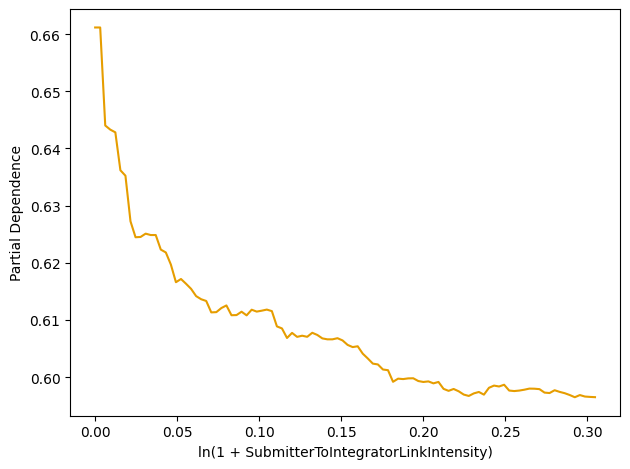

In [27]:
from python_proj.modelling.notebooks.random_forest.rf_functions import create_model
from python_proj.modelling.notebooks.random_forest.pd_functions import (
    create_partial_dependence_plots,
)

full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

output_path = f"{figure_base_path}/partial-dependence/"
create_partial_dependence_plots(full_rf_model, test_predictors, output_path)

### Mean decrease in Impurity

/tmp/ipykernel_43386/72007592.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


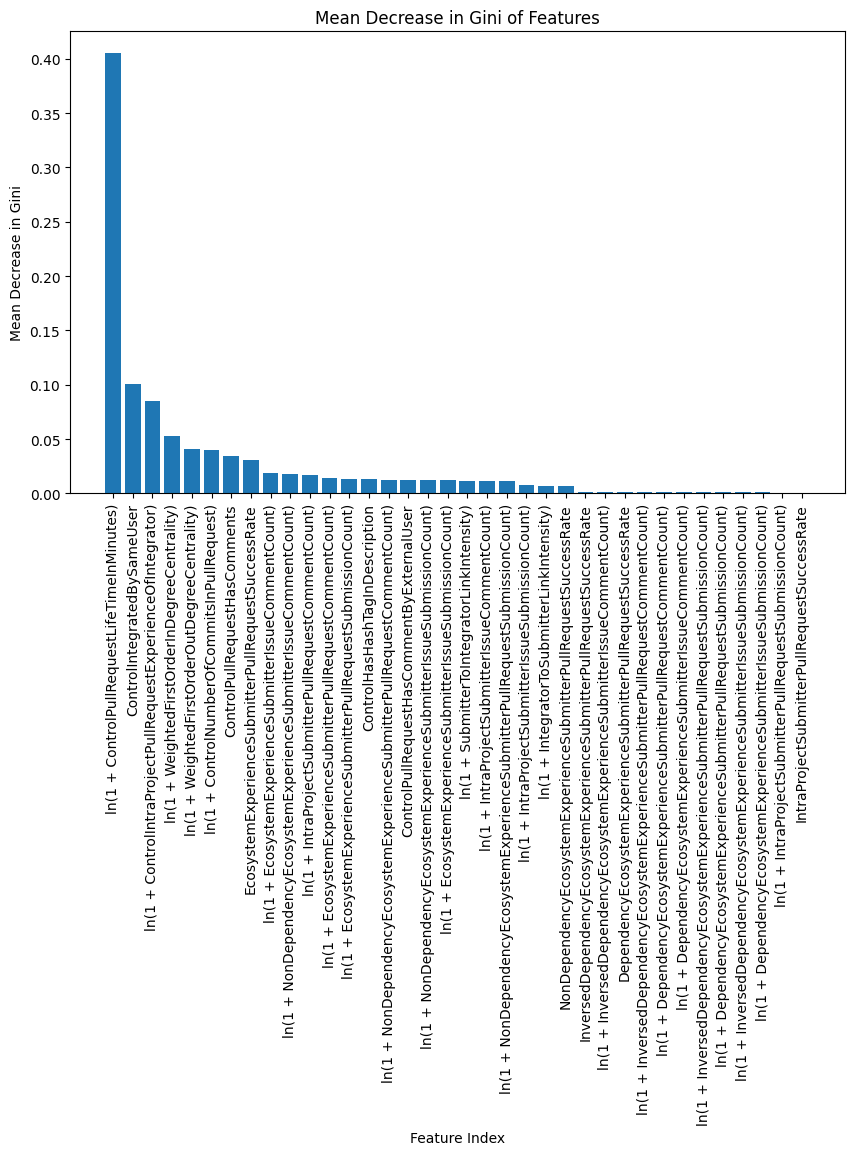

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.4050
ControlIntegratedBySameUser: 0.1010
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.0847
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0531
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0408
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0400
ControlPullRequestHasComments: 0.0342
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0309
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0184
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.0176
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.0173
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0137
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0135
ControlHasHashTagInDescription: 0.0132
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.0125
ControlPullRequestHasCommentByExternalUser: 0.0123
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount): 0.0122
l

In [28]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(entry)
        print(entry)

### Variable Group Ablation Studies

Performs an ablation and a reverse ablation study using different feature groups:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [29]:
from python_proj.utils.util import get_matching

# Generates variable groups

var_group_regex_patterns = [
    ("control", r".*Control.*"),
    ("intra", r"^(?!.*Control).*(?=Intra).*"),
    ("eco", r"^(?!.*Dependency).*(?=Ecosystem).*"),
    ("deco", r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    ("ideco", r".*(?=Inverse).*"),
    ("ndeco", r".*(?=NonDependency).*"),
    ("coll", r".*(Weighted|LinkIntensity).*"),
]

var_groups = [
    (name, list(get_matching(independent_fields, pattern)))
    for name, pattern in var_group_regex_patterns
]

#### Regular Ablation
Creates models with subsets of the features to test their impact on the predictions in isolation.

In [30]:
abl_results = dict()

for cluster_name, cluster in var_groups:
    used_fields = list([field for field in independent_fields if field not in cluster])
    print(
        f'Ablation with "{cluster_name}", excluding: {list(cluster)}, including: {used_fields}.'
    )

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, used_fields, k, pr_merged_key, seed_counter
    )
    abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )


# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Ablation with "control", excluding: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'], including: ['IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

random_state=50random_state=50

random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.727321700433306, 'precision': 0.7744153367459601, 'recall': 0.8253048563074948, 'f1': 0.7990506602226632}

Confusion matrix:
[[15813 13485]
 [ 9799 46293]]

Classification report:
              precision    recall  f1-score   support

       False       0.62      0.54      0.58     29298
        True       0.77      0.83      0.80     56092

    accuracy                           0.73     85390
   macro avg       0.70      0.68      0.69     85390
weighted avg       0.72      0.73      0.72     85390

metrics={'accuracy': 0.7226373111605574, 'precision': 0.7728347050639489, 'recall': 0.8198339171719686, 'f1': 0.7956408442197179}

Confusion matrix:
[[15601 13552]
 [10132 46105]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.54      0.57     29153
        True       0.77      0.82      0.80     56237

    accuracy          

#### Reverse ablation

Performs a reverse ablation study, such that models are created using ONLY the subset of variables.

In [31]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups:
    print(f'Reverse ablation with "{cluster_name}", including: {list(cluster)}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

# Prints summarized results again for clarity.
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(
        f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=64
random_state=64random_state=64

random_state=64
random_state=64
metrics={'accuracy': 0.7257055861342078, 'precision': 0.7761778789806785, 'recall': 0.821775508757002, 'f1': 0.7983261292600182}

Confusion matrix:
[[15610 13368]
 [10054 46358]]

Classification report:
              precision    recall  f1-score   support

       False       0.61      0.54      0.57     28978
        True       0.78      0.82      0.80     56412

    accuracy                           0.73     85390
   macro avg       0.69      0.68      0.68     85390
weighted avg       0.72      0.73      0.72     85390

metrics={'accuracy': 0.724136315727837, 'p

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [32]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.6581168755123551.
{
    "accuracy": 0.5491392434711324,
    "precision": 0.6569782992457338,
    "recall": 0.6566855594767048,
    "f1": 0.6568318967438296
}


In [33]:
import datetime

print(datetime.datetime.now())

2024-01-30 14:17:56.265297
